In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [93]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import pandas
import datetime
pandas.options.display.max_columns = None

import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.colors
import watershed_workflow.condition
import watershed_workflow.mesh
import watershed_workflow.split_hucs
import watershed_workflow.land_cover_properties

watershed_workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)


In [ ]:
#from shapely.ops import unary_union

In [3]:
# specify the input shapefile and a hint as to what HUC it is in.
wade_shapefile = 'EM_bound.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
simplify = 30 # length scale to target average edge
hucs = ['060102070302']
name = "efpc"

# start and end of simulation -- one year of simulation that is in both the MODIS and DayMet dataset ranges
start = datetime.date(2023,1,1)
end = datetime.date(2023,12,31)

logging.info("")
logging.info("Meshing shape: {}".format(wade_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, wade_intensive = watershed_workflow.get_split_form_shapes(wade_shapefile)

2025-06-16 23:12:06,451 - root - INFO: 
2025-06-16 23:12:06,453 - root - INFO: Meshing shape: EM_bound.shp
2025-06-16 23:12:06,455 - root - INFO: ==============================
2025-06-16 23:12:06,457 - root - INFO: 
2025-06-16 23:12:06,459 - root - INFO: Loading shapes
2025-06-16 23:12:06,460 - root - INFO: ------------------------------
2025-06-16 23:12:06,460 - root - INFO: Loading file: 'EM_bound.shp'
2025-06-16 23:12:07,462 - root - INFO: ... found 1 shapes
2025-06-16 23:12:07,462 - root - INFO: Converting to shapely
2025-06-16 23:12:07,464 - root - INFO:  ... done
2025-06-16 23:12:07,469 - root - INFO: Removing holes on 1 polygons
2025-06-16 23:12:07,470 - root - INFO:   -- removed interior
2025-06-16 23:12:07,471 - root - INFO:   -- union
2025-06-16 23:12:07,471 - root - INFO: Parsing 1 components for holes
2025-06-16 23:12:07,471 - root - INFO:   -- complete


In [4]:
intensive_poly=wade_intensive.exterior()

In [5]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerSoilGrids2017()

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# Note we also prepopulate some data for MODIS data as well.
#
#sources['land cover'] = workflow.source_list.FileManagerRaster()ources['geologic structure'] = watershed_workflow.source_list.FileManagerGLHYMPS()
#sources['depth to bedrock'] = workflow.source_list.FileManagerRaster()
sources['geologic structure'] = watershed_workflow.source_list.FileManagerGLHYMPS()
watershed_workflow.source_list.log_sources(sources)

2025-06-16 23:12:21,416 - root - INFO: Using sources:
2025-06-16 23:12:21,417 - root - INFO: --------------
2025-06-16 23:12:21,418 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2025-06-16 23:12:21,418 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2025-06-16 23:12:21,420 - root - INFO: DEM: National Elevation Dataset (NED)
2025-06-16 23:12:21,421 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-06-16 23:12:21,422 - root - INFO: geologic structure: GLHYMPS version 2.0
2025-06-16 23:12:21,422 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2019_Land_Cover_L48
2025-06-16 23:12:21,423 - root - INFO: lai: MODIS
2025-06-16 23:12:21,423 - root - INFO: depth to bedrock: SoilGrids2017
2025-06-16 23:12:21,424 - root - INFO: meteorology: DayMet 1km


In [7]:
_, wade_shapefile = watershed_workflow.get_shapes('EM_bound.shp')
wade_shapefiles=wade_shapefile[0]
# find the rivers in this shape
_, reaches = watershed_workflow.get_reaches(watershed_workflow.source_list.hydrography_sources['NHD Plus'],
                                            '0601', wade_shapefiles.bounds, crs, crs, merge=False)

# filter rivers to the huc shape
reaches = watershed_workflow.utils.filter_to_shape(wade_shapefiles, reaches)

# make the global tree
rivers = watershed_workflow.hydrography.createGlobalTree(reaches)

# check that only one tree was formed
#assert(len(rivers) == 1)

2025-06-16 23:13:10,363 - root - INFO: 
2025-06-16 23:13:10,364 - root - INFO: Loading shapes
2025-06-16 23:13:10,364 - root - INFO: ------------------------------
2025-06-16 23:13:10,365 - root - INFO: Loading file: 'EM_bound.shp'
2025-06-16 23:13:10,392 - root - INFO: ... found 1 shapes
2025-06-16 23:13:10,393 - root - INFO: Converting to shapely
2025-06-16 23:13:10,394 - root - INFO:  ... done
2025-06-16 23:13:10,395 - root - INFO: 
2025-06-16 23:13:10,395 - root - INFO: Loading Hydrography
2025-06-16 23:13:10,396 - root - INFO: ------------------------------
2025-06-16 23:13:10,396 - root - INFO: Loading streams in HUC 0601
2025-06-16 23:13:10,397 - root - INFO:          and/or bounds (745894.2031483874, 181532.93992261216, 746351.9387712777, 182011.42703942582)
2025-06-16 23:13:10,511 - root - INFO:   REST URL: https://tnmaccess.nationalmap.gov/api/v1/products?datasets=National+Hydrography+Dataset+Plus+High+Resolution+%28NHDPlus+HR%29&polyType=huc4&polyCode=0601
2025-06-16 23:13:1

/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


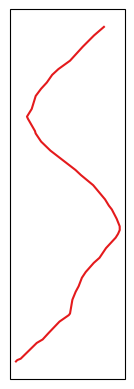

In [10]:
river = rivers[0]
watershed_workflow.plot.rivers([river,], crs)

In [12]:
# load the huc
my_hucs = []
for huc in hucs:
   _, ws = watershed_workflow.get_huc(sources['HUC'], huc, crs)
   my_hucs.append(ws)


#watershed_containing_basin = unary_union([huc.geometry if hasattr(huc, 'geometry') else huc for huc in my_hucs])
watershed_containing_basin = shapely.ops.cascaded_union(my_hucs)

2025-06-16 23:18:12,893 - root - INFO: 
2025-06-16 23:18:12,894 - root - INFO: Loading HUC 060102070302
2025-06-16 23:18:12,894 - root - INFO: ------------------------------
2025-06-16 23:18:12,895 - root - INFO: 
2025-06-16 23:18:12,895 - root - INFO: Loading level 12 HUCs in 060102070302
2025-06-16 23:18:12,895 - root - INFO: ------------------------------
2025-06-16 23:18:12,919 - root - INFO: Using HUC file "/home/jovyan/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2025-06-16 23:18:13,769 - root - INFO: ... found 1 HUCs
2025-06-16 23:18:13,770 - root - INFO:   -- 060102070302
2025-06-16 23:18:13,772 - root - INFO: Converting to out_crs
2025-06-16 23:18:13,816 - root - INFO: Converting to shapely
2025-06-16 23:18:13,817 - root - INFO:  ... done
2025-06-16 23:18:13,818 - root - INFO: ... found 1


In [13]:
#getting all the reaches and river in the basin
include_rivers=True
ignore_small_rivers=2
prune_by_area_fraction=0.001 #keep as many reaches as possible
if include_rivers: 
   # download/collect the river network within that shape's bounds
   _, reaches_raw = watershed_workflow.get_reaches(sources['hydrography'], "0601",
                                               watershed_containing_basin, crs, crs,
                                               in_network=True, properties=True, include_catchments=True)
  
   rivers_raw = watershed_workflow.construct_rivers(reaches_raw, method='hydroseq',
                                                ignore_small_rivers=ignore_small_rivers,
                                                prune_by_area=prune_by_area_fraction*watershed_containing_basin.area*1e-6,
                                                remove_diversions=True,
                                                remove_braided_divergences=True)

2025-06-16 23:18:19,036 - root - INFO: 
2025-06-16 23:18:19,037 - root - INFO: Loading Hydrography
2025-06-16 23:18:19,037 - root - INFO: ------------------------------
2025-06-16 23:18:19,037 - root - INFO: Loading streams in HUC 0601
2025-06-16 23:18:19,038 - root - INFO:          and/or bounds (745457.8350267619, 177908.63547428328, 759759.3361214856, 189777.77081155678)
2025-06-16 23:18:19,065 - root - INFO:   Using Hydrography file "/home/jovyan/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2025-06-16 23:18:19,065 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/home/jovyan/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb' layer 'NHDFlowline' for streams in '(745457.8350267619, 177908.63547428328, 759759.3361214856, 189777.77081155678)'
2025-06-16 23:20:26,860 - root - INFO:   Found total of 743 in bounds.
2025-06-16 23:20:26,865 - root - INFO: Filtering reaches not in-network
2025-06-16 23:20:26,873 - root - INFO:   Nation

/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/opt/conda/li

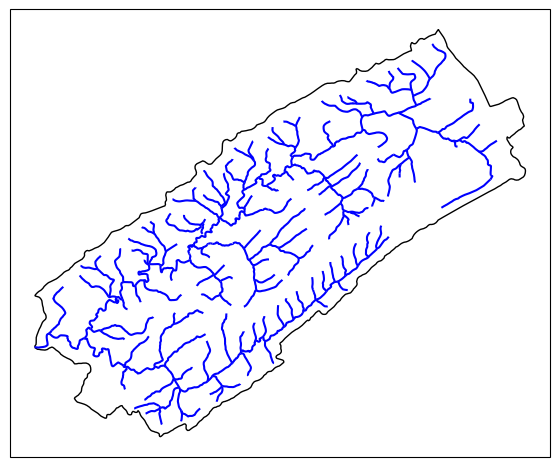

In [14]:
generate_plots=True
if generate_plots:
   fig = plt.figure(figsize=figsize)
   ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])   
   watershed_workflow.plot.shply(watershed_containing_basin, crs, 'k', ax)
   watershed_workflow.plot.rivers(rivers_raw, crs, ['b'], ax)


   plt.show()

In [38]:
#nhdids = ["25000400170075"]
#nhdids = ["25000400035488"] # urban id
nhdids = ["250004000013618"]
names = ['domain_outlet']


for id, name in zip(nhdids, names):
   print(id, name)

250004000013618 domain_outlet


In [45]:
getNode(nhdids , rivers)

StopIteration: 

In [39]:
def getNode(nhd_id , rivers):
   node = next(river.getNode(nhd_id) for river in rivers if river.getNode(nhd_id) != None)
   return node


def get_subDomain(id, subdomains):
   subdomain_index = next((index, subdomain) for index, subdomain in enumerate(subdomains) if subdomain.properties['outlet_ID'] == id)
   index, subdomain = subdomain_index
   return index, subdomain
def find_reaches(rivers, ids):
   reaches = []
   for nhdid in ids:
       found = False
       for river in rivers:
           n = river.getNode(nhdid)
           if n is not None:
               found = True
               reaches.append(n)
               break
       if not found:
           reaches.append(None)
   return reaches

In [40]:
# now that we are done modifying, we must compute our own contributing areas on this new network
for river in rivers_raw:
   river.accumulate('CatchmentAreaSqKm', to_save='ContributingAreaSqKm')


# reset the reaches raw, now that we are done manipulating
reaches_raw = [r for river in rivers_raw for r in river]


In [41]:
# make a copy of the rivers_raw and compute pruned rivers
rivers = [r.deepcopy() for r in rivers_raw]


# note the conversion to sq km, because the default property is TotalDrainageAreaSqKm which is in km^2
rivers = watershed_workflow.reduce_rivers(rivers,
                                         ignore_small_rivers=ignore_small_rivers,
                                         prune_by_area=(prune_by_area_fraction *
                                                           watershed_containing_basin.area * 1.e-6),
                                         area_property='ContributingAreaSqKm',
                                         remove_diversions=True,
                                         remove_braided_divergences=True)

2025-06-16 23:53:47,201 - root - INFO: Removing rivers with fewer than 2 reaches.
2025-06-16 23:53:47,202 - root - INFO: ... removed 0 rivers
2025-06-16 23:53:47,203 - root - INFO: Removing rivers with area < 0.07683185676941523
2025-06-16 23:53:47,203 - root - INFO: Removing divergent sections...
2025-06-16 23:53:47,204 - root - INFO:   ... removed 0 divergence tributaries with 0 total reaches.
2025-06-16 23:53:47,204 - root - INFO:   ... removed 0 divergence tributaries with 0 total reaches.
2025-06-16 23:53:47,205 - root - INFO: Pruning by total contributing area < 0.07683185676941523
2025-06-16 23:53:47,206 - root - INFO: ... pruned 0
2025-06-16 23:53:47,206 - root - INFO: Removing rivers with fewer than 2 reaches.
2025-06-16 23:53:47,207 - root - INFO: ... removed 0 rivers


In [42]:

trunk_reaches = find_reaches(rivers_raw, nhdids)
assert(all(tr is not None for tr in trunk_reaches))


trunk_reaches_pruned = find_reaches(rivers, nhdids)
assert(all(tr is not None for tr in trunk_reaches))
print([i for (i,tr) in enumerate(trunk_reaches_pruned) if tr is None])

AssertionError: 

In [43]:
trunk_reaches

[None]

In [23]:
trunk_reaches, incremental_cas = watershed_workflow.river_tree.accumulateIncrementalCatchments(rivers_raw, nhdids, names)

AssertionError: 

In [30]:
# some contributing areas are discontinuous -- this is physically wrong, but what can you do?
incremental_cas2 = []
for poly in incremental_cas:
   if isinstance(poly, shapely.geometry.Polygon):
       incremental_cas2.append(poly)
   else:
       incremental_cas2.append(watershed_workflow.split_hucs.biggest(poly))
       incremental_cas2[-1].properties = poly.properties
incremental_cas = incremental_cas2

NameError: name 'incremental_cas' is not defined

In [31]:
# sort the trunks by CA size -- this isn't needed but allows for nicer plots later
sorted_pairs = sorted(zip(trunk_reaches, trunk_reaches_pruned, incremental_cas), key=lambda a : a[0].properties['ContributingAreaSqKm'], reverse=True)
trunk_reaches = [i[0] for i in sorted_pairs]
trunk_reaches_pruned = [i[1] for i in sorted_pairs]
incremental_cas = [i[2] for i in sorted_pairs]


assert(all(hasattr(poly, 'properties') for poly in incremental_cas))
assert(all(isinstance(poly, shapely.geometry.Polygon) for poly in incremental_cas))

NameError: name 'incremental_cas' is not defined

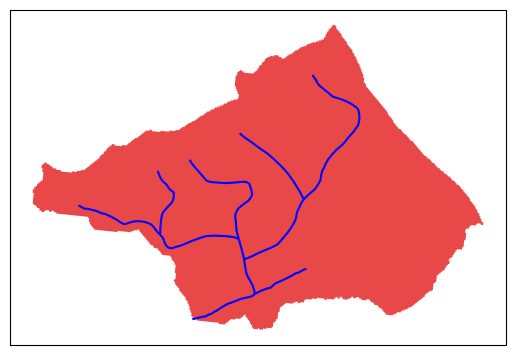

In [16]:
subdomains = watershed_workflow.utils.deepcopy(incremental_cas)


fig, ax = watershed_workflow.plot.get_ax(crs)
#watershed_workflow.plot.shply(watershed_containing_basin, crs, 'r', ax)
watershed_workflow.plot.shplys(subdomains, crs, None, ax, facecolor='edge', alpha=0.8)
watershed_workflow.plot.rivers(trunk_reaches,crs, 'b', ax)

In [17]:
watershed = watershed_workflow.split_hucs.SplitHUCs(subdomains)

2024-07-28 13:46:52,077 - root - INFO: Removing holes on 1 polygons
2024-07-28 13:46:52,079 - root - INFO:   -- removed interior
2024-07-28 13:46:52,081 - root - INFO:   -- union
2024-07-28 13:46:52,084 - root - INFO: Parsing 1 components for holes
2024-07-28 13:46:52,085 - root - INFO:   -- complete


In [18]:
rivers=[river.deepcopy() for river in trunk_reaches]

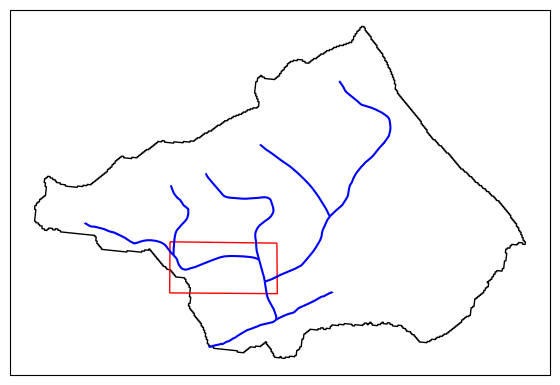

In [19]:
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])   

watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
watershed_workflow.plot.rivers(rivers, crs, 'b', ax)
watershed_workflow.plot.shply(intensive_poly, crs, 'r', ax)

In [20]:
watershed.exterior().area/1e6

4.77285675319509

2025-06-17 01:00:33,498 - root - INFO: 
2025-06-17 01:00:33,499 - root - INFO: Triangulation
2025-06-17 01:00:33,500 - root - INFO: ------------------------------
2025-06-17 01:00:33,557 - root - INFO: Triangulating...
2025-06-17 01:00:33,559 - root - INFO:    8 points and 8 facets
2025-06-17 01:00:33,560 - root - INFO:  checking graph consistency
2025-06-17 01:00:33,560 - root - INFO:  tolerance is set to 1
2025-06-17 01:00:33,564 - root - INFO:  building graph data structures
2025-06-17 01:00:33,565 - root - INFO:  triangle.build...
2025-06-17 01:00:35,495 - root - INFO:   ...built: 3748 mesh points and 7310 triangles
2025-06-17 01:00:35,496 - root - INFO: Plotting triangulation diagnostics
2025-06-17 01:00:35,858 - root - INFO:   min area = 1.640289306640625
2025-06-17 01:00:35,859 - root - INFO:   max area = 19.97669219970703


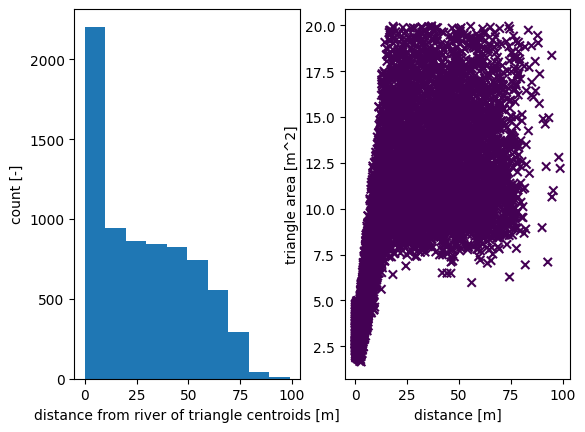

In [48]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.

d0 = 2; d1 =15
A0 = 5; A1 = 20

#d0 = 100; d1 = 500
#A0 = 3000; A1 = 1000

# Refine triangles if they get too acute
min_angle = 15 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, dists = watershed_workflow.triangulate(wade_intensive, rivers=rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)


2024-07-28 13:49:11,402 - root - INFO: 
2024-07-28 13:49:11,403 - root - INFO: Triangulation
2024-07-28 13:49:11,405 - root - INFO: ------------------------------
2024-07-28 13:49:11,570 - root - INFO: Triangulating...
2024-07-28 13:49:11,574 - root - INFO:    932 points and 932 facets
2024-07-28 13:49:11,575 - root - INFO:  checking graph consistency
2024-07-28 13:49:11,576 - root - INFO:  tolerance is set to 1
2024-07-28 13:49:11,586 - root - INFO:  building graph data structures
2024-07-28 13:49:11,594 - root - INFO:  triangle.build...
2024-07-28 13:50:14,806 - root - INFO:   ...built: 6297 mesh points and 11432 triangles
2024-07-28 13:50:14,808 - root - INFO: Plotting triangulation diagnostics
2024-07-28 13:50:16,346 - root - INFO:   min area = 39.63848876953125
2024-07-28 13:50:16,347 - root - INFO:   max area = 9892.976654052734


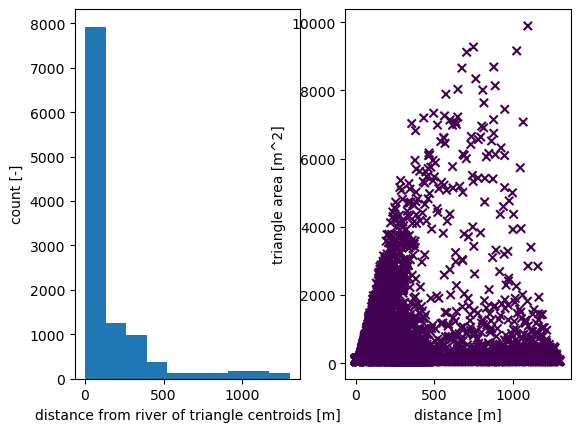

In [21]:

d0 = 25; d1 = 500
A0 = 150; A1 = 10000

#d0 = 100; d1 = 500
#A0 = 3000; A1 = 1000

# Refine triangles if they get too acute
min_angle = 30 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, dists = watershed_workflow.triangulate(watershed, rivers=rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)

In [50]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape('data/dem/USGS_NED_1as_n37_w085.tif', wade_intensive.exterior(), crs)
# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

2025-06-17 01:01:55,644 - root - INFO: 
2025-06-17 01:01:55,646 - root - INFO: Loading Raster
2025-06-17 01:01:55,647 - root - INFO: ------------------------------
2025-06-17 01:01:55,648 - root - INFO: Loading file: 'data/dem/USGS_NED_1as_n37_w085.tif'
2025-06-17 01:01:55,649 - root - INFO: Collecting raster
2025-06-17 01:03:00,839 - root - INFO: bounds in my_crs: (736045.7798706728, 3982533.306083485, 736507.0854099996, 3983008.936896373)
2025-06-17 01:03:00,969 - root - INFO: ... got raster of shape: (476, 463)
2025-06-17 01:03:00,970 - root - INFO: ... got raster bounds: (736045.0, 3983009.0, 736508.0, 3982533.0)


In [20]:
# get a raster for the elevation map, based on NED
dem_1m='./data/dem/1m_dem.tif'
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)
#dem_profile, dem = watershed_workflow.get_raster_on_shape(dem_1m, watershed.exterior(), crs)
# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

# # download the needed rasters
#dem_1m='./data/dem/efpc_dem1m.tif'
#

NameError: name 'watershed' is not defined

[Text(181400.0, 0, ''),
 Text(181500.0, 0, ''),
 Text(181600.0, 0, ''),
 Text(181700.0, 0, ''),
 Text(181800.0, 0, ''),
 Text(181900.0, 0, ''),
 Text(182000.0, 0, ''),
 Text(182100.0, 0, '')]

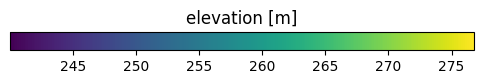

In [51]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = watershed_workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())

/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'elevation [m]')

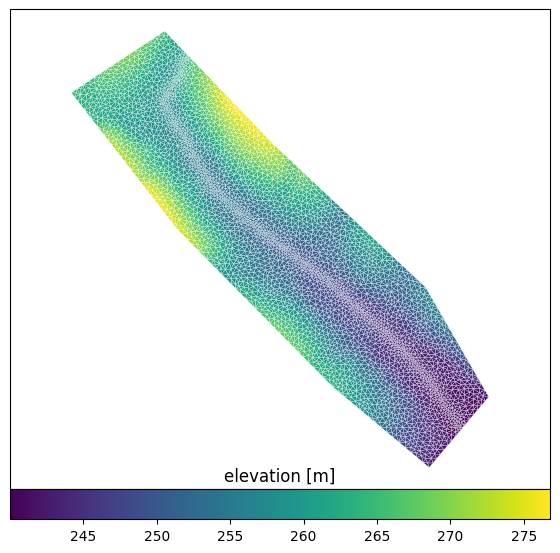

In [55]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = watershed_workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
#ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

#xlim = (2477441.626758025, 2483499.237963988)
#ylim = (615352.6112498859, 618962.9407894457)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
#watershed_workflow.plot.hucs(wade_intensive, crs, ax=ax, color='k', linewidth=1)
#watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')

#mp2 = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                 color='elevation', edgecolor='white', linewidth=0.2)
#watershed_workflow.plot.hucs(wade, crs, ax=ax2, color='k', linewidth=1)
#watershed_workflow.plot.rivers(rivers, crs, ax=ax2, color='red', linewidth=1.5)
#ax2.set_xlim(xlim)
#ax2.set_ylim(ylim)
#ax2.set_xticks([])
#ax2.set_yticks([])
#
#ax.indicate_inset_zoom(ax2, edgecolor='k')
#
#
#print(ax.get_xlim())
#print(ax.get_ylim())
cbar.ax.set_title('elevation [m]')

max diff =  0.5444612606158614


/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


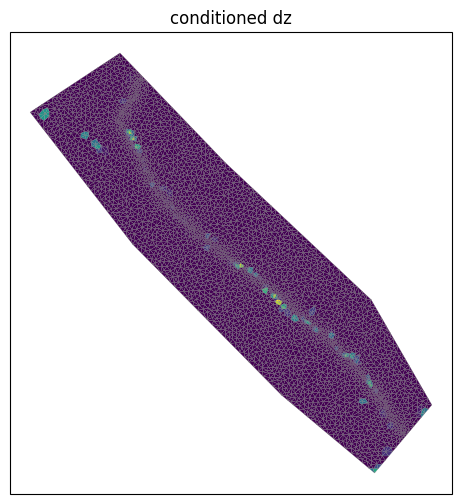

In [57]:
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))
# hydrologically condition the mesh, removing pits
watershed_workflow.condition.fill_pits(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
watershed_workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

Text(0.5, 1.0, 'elevation [m]')

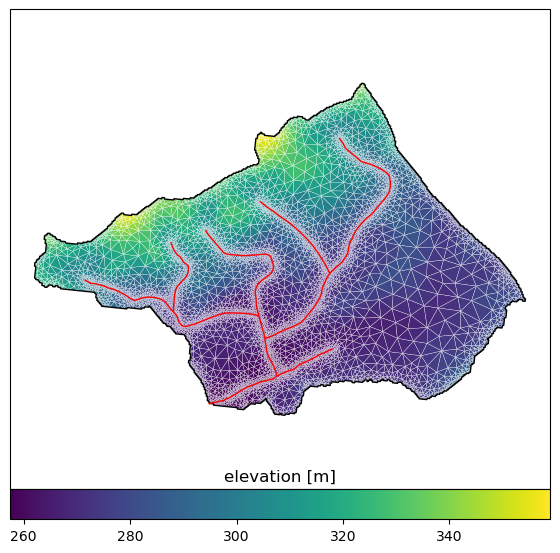

In [23]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = watershed_workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
#ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])


mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')

#mp2 = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                 color='elevation', edgecolor='white', linewidth=0.2)
#watershed_workflow.plot.hucs(wade, crs, ax=ax2, color='k', linewidth=1)
#watershed_workflow.plot.rivers(rivers, crs, ax=ax2, color='red', linewidth=1.5)
#ax2.set_xlim(xlim)
#ax2.set_ylim(ylim)
#ax2.set_xticks([])
#ax2.set_yticks([])
#
#ax.indicate_inset_zoom(ax2, edgecolor='k')
#
#
#print(ax.get_xlim())
#print(ax.get_ylim())
cbar.ax.set_title('elevation [m]')
#%matplotlib ipympl

In [24]:
import ipympl
%matplotlib ipympl

In [25]:
#pip install ipympl

In [26]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

max diff =  2.9089296376531593


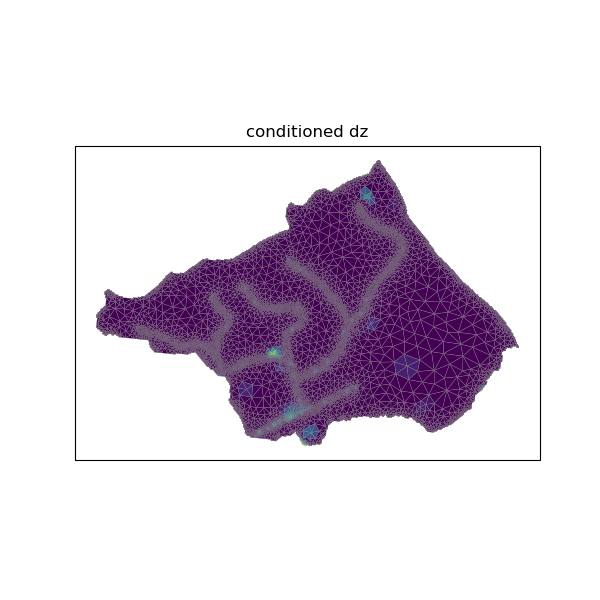

In [27]:
# hydrologically condition the mesh, removing pits
watershed_workflow.condition.fill_pits(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
watershed_workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

In [28]:
# download the NLCD raster
lc_profile, lc_raster = watershed_workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = watershed_workflow.values_from_raster(m2.centroids, crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2024-07-28 13:51:45,053 - root - INFO: 
2024-07-28 13:51:45,054 - root - INFO: Loading Raster
2024-07-28 13:51:45,055 - root - INFO: ------------------------------
2024-07-28 13:51:45,058 - root - INFO: Collecting raster
2024-07-28 13:51:45,061 - root - INFO:   filename: /Users/mosesadebayo/Desktop/WADE_SFA_model/watershed Worksflow/data/Land_Cover/NLCD_2019_Land_Cover_L48/NLCD_2019_Land_Cover_L48.img
2024-07-28 13:51:45,374 - root - INFO: ... got raster of shape: (87, 124)
2024-07-28 13:51:45,484 - root - INFO: ... got raster bounds: (1043835.0, 1506975.0, 1047555.0, 1504365.0)
2024-07-28 13:51:45,869 - root - INFO: Found land cover dtypes: uint8
2024-07-28 13:51:45,871 - root - INFO: Found land cover types: {0, 71, 41, 42, 43, 81, 52, 21, 22, 23, 24}


/usr/local/anaconda3/envs/watershed_workflow-2022-08-29/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x163084670>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x163084310>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [23 23 21 ... 23 22 23]


Text(0.5, 1.0, 'NLCD land cover index')

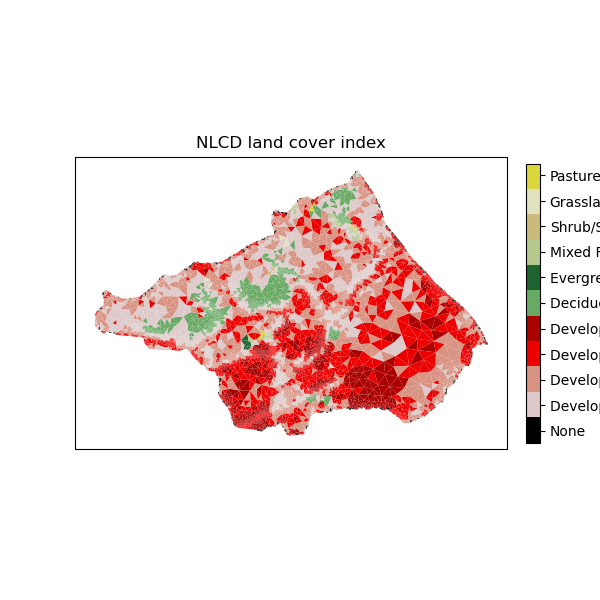

In [29]:
# plot the NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                watershed_workflow.colors.generate_nlcd_colormap(lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, 
                                     norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(nlcd_indices), cmap=nlcd_cmap, 
                                         labels=nlcd_labels) 
ax.set_title("NLCD land cover index")

In [30]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], [watershed.exterior(),],
                                      crs, crs, properties=True)


# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array(soil_survey_props['mukey'][:], np.int32)
    
# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    watershed.exterior().bounds, 10, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)



2024-07-28 13:51:59,162 - root - INFO: 
2024-07-28 13:51:59,163 - root - INFO: Loading shapes
2024-07-28 13:51:59,164 - root - INFO: ------------------------------
2024-07-28 13:51:59,183 - root - INFO: Attempting to download source for target '/Users/mosesadebayo/Desktop/WADE_SFA_model/watershed Worksflow/data/soil_structure/SSURGO/SSURGO_-84.2834_36.0083_-84.2417_36.0316.shp'
2024-07-28 13:51:59,205 - root - INFO:   Found 119 shapes.
2024-07-28 13:51:59,207 - root - INFO:   and crs: epsg:4326
2024-07-28 13:51:59,209 - root - INFO:   Downloaded 119 total shapes
2024-07-28 13:51:59,209 - root - INFO:   Downloaded 29 unique mukeys
2024-07-28 13:51:59,303 - root - INFO: found 29 unique MUKEYs.
2024-07-28 13:52:00,994 - root - INFO: Running Rosetta for van Genutchen parameters
2024-07-28 13:52:01,351 - root - INFO:   ... done
2024-07-28 13:52:01,357 - root - INFO:   requested 27 values
2024-07-28 13:52:01,359 - root - INFO:   got 27 responses
2024-07-28 13:52:01,388 - root - INFO: ... fou

In [31]:
soil_survey_props.iloc[25,1:-1]=soil_survey_props.iloc[24,1:-1]/2+soil_survey_props.iloc[26,1:-1]/2
soil_survey_props.iloc[28,1:-1]=soil_survey_props.iloc[27,1:-1]/2+soil_survey_props.iloc[26,1:-1]/2

In [32]:
soil_survey_props

mukey  residual saturation [-]  Rosetta porosity [-]  \
0   1887357                 0.217554              0.423481   
1   1887358                 0.229867              0.410507   
2   1887360                 0.245552              0.384051   
3   1887366                 0.261123              0.432463   
4   1887367                 0.261123              0.432463   
5   1887368                 0.277201              0.444684   
6   1887371                 0.271178              0.434995   
7   1887374                 0.311210              0.423916   
8   1887375                 0.301130              0.447643   
9   1887376                 0.308668              0.427314   
10  1887377                 0.306929              0.440348   
11  1887382                 0.285822              0.446531   
12  1887383                 0.212813              0.403472   
13  1887384                 0.258378              0.410349   
14  1887385                 0.258247              0.410262   
15  1887391                 0.285583              0.454999   
16  1887392                 0.288154              0.431431   
17  1887393                 0.288154              0.431431   
18  1887407                 0.273730              0.421675   
19  1887408                 0.273730              0.421675   
20  1887409                 0.224951              0.434665   
21  1887410                 0.223665              0.434238   
22  1887414                 0.248173              0.412228   
23  1887416                 0.268115              0.418216   
24  1887438                 0.268183              0.499335   
25  1887439                 0.276001              0.470837   
26  1894850                 0.283820              0.442339   
27  1894851                 0.283820              0.442339   
28  2567655                 0.283820              0.442339   

    van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
0                      0.000038             1.477078   
1                      0.000049             1.426456   
2                      0.000079             1.353111   
3                      0.000049             1.376752   
4                      0.000049             1.376752   
5                      0.000059             1.329857   
6                      0.000061             1.335003   
7                      0.000091             1.240694   
8                      0.000076             1.269253   
9                      0.000091             1.243406   
10                     0.000076             1.264723   
11                     0.000062             1.313767   
12                     0.000064             1.426003   
13                     0.000076             1.334977   
14                     0.000076             1.335279   
15                     0.000079             1.281728   
16                     0.000078             1.283647   
17                     0.000078             1.283647   
18                     0.000058             1.340444   
19                     0.000058             1.340444   
20                     0.000047             1.435498   
21                     0.000046             1.439611   
22                     0.000081             1.345931   
23                     0.000075             1.319346   
24                     0.000084             1.287994   
25                     0.000072             1.303141   
26                     0.000061             1.318289   
27                     0.000061             1.318289   
28                     0.000061             1.318289   

    Rosetta permeability [m^2]  thickness [cm]  permeability [m^2]  \
0                 1.541295e-13      154.550000        8.277264e-13   
1                 1.260094e-13      152.520000        9.170000e-13   
2                 8.675030e-14      123.800000        9.446941e-13   
3                 8.519305e-14       77.160000        2.334663e-13   
4                 8.519305e-14       87.500000        2.039371e-13   
5                 7.561319e-14       89.0000

/usr/local/anaconda3/envs/watershed_workflow-2022-08-29/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x16520ada0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x165209570>}
setting face color =  [1887392. 1887392. 1887392. ... 1887439. 1887374. 1887374.]


(754562.7215, 758630.3565, 187140.82935, 189891.87764999998)

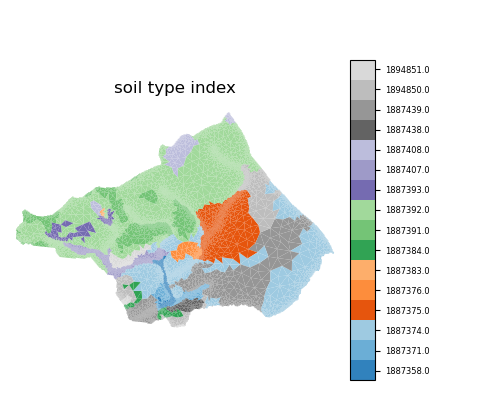

In [33]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = \
        watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.7,0.05,0.05,0.8])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm=norm
                       )

cbar = watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), 
                                                cmap=cmap, labels=labels, cax=cax)
cbar.ax.tick_params(labelsize=6)

ax.set_title('soil type index')
ax.axis('off')

Index(['mukey', 'residual saturation [-]', 'Rosetta porosity [-]',
       'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]',
       'Rosetta permeability [m^2]', 'thickness [cm]', 'permeability [m^2]',
       'porosity [-]', 'bulk density [g/cm^3]', 'total sand pct [%]',
       'total silt pct [%]', 'total clay pct [%]', 'source'],
      dtype='object')
min, max =  0.30148257701438635 0.4993354626674704


(754562.7215, 758630.3565, 187140.82935, 189891.87764999998)

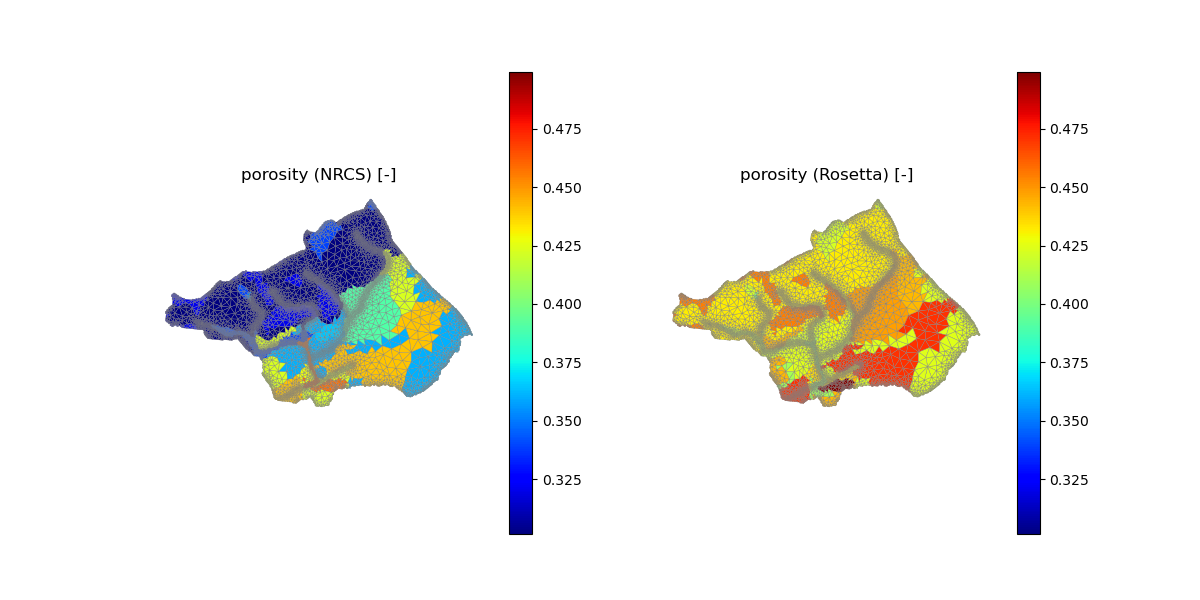

In [34]:
# Note this is not just the soil ID, but also soil properties.  
print(soil_survey_props.keys())
soil_survey_props.set_index('mukey', inplace=True)

# To demonstrate what we mean by this, plot the porosity of the soil column.
porosity_nrcs = np.empty(soil_color.shape, 'd')
porosity_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    porosity_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'porosity [-]']
    porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta porosity [-]']

pmin = min(np.nanmin(porosity_nrcs), np.nanmin(porosity_rosetta))
pmax = max(np.nanmax(porosity_nrcs), np.nanmax(porosity_rosetta))
print('min, max = ', pmin, pmax)


fig = plt.figure(figsize=(12,6))
ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('porosity (NRCS) [-]')
ax1.axis('off')


ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=porosity_rosetta, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('porosity (Rosetta) [-]')
ax2.axis('off')


(754562.7215, 758630.3565, 187140.82935, 189891.87764999998)

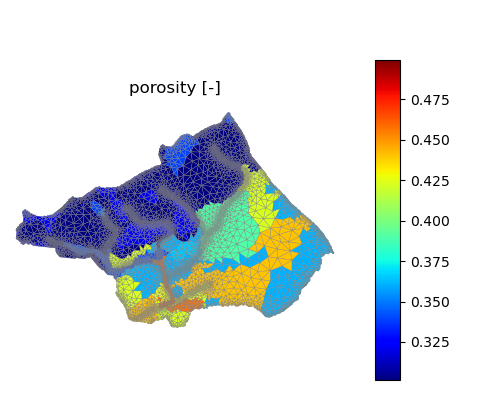

In [35]:
# plot the soil porosity again
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.75,0.05,0.05,0.8])

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp, cax=cax)

ax.set_title('porosity [-]')
ax.axis('off')

min = -13.471430647610822, max = -11.59812327610077


Text(0.5, 1.0, 'log permeability (Rosetta) [m^2]')

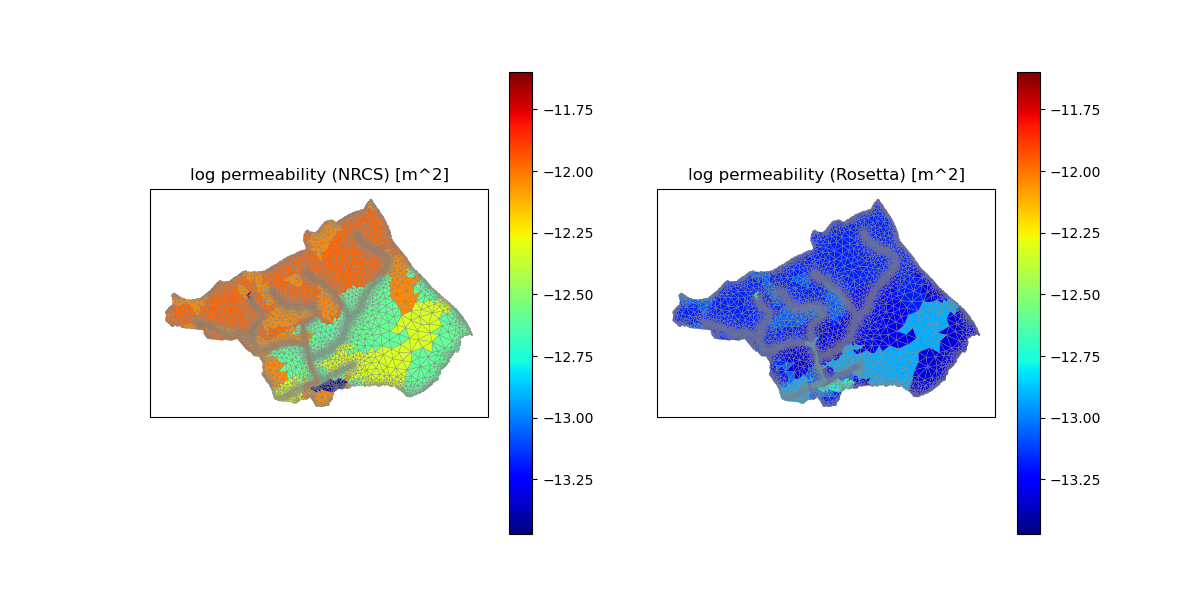

In [36]:
# averaging permeability is a tricky beast.  we average in log space, check that 
# unit conversions make sense
fig = plt.figure(figsize=(12,6))
soil_perm_nrcs = np.empty(soil_color.shape, 'd')
soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    soil_perm_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'permeability [m^2]']
    soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta permeability [m^2]']

pmin = min(np.log10(soil_perm_nrcs).min(), np.log10(soil_perm_rosetta).min())
pmax = max(np.log10(soil_perm_nrcs).max(), np.log10(soil_perm_rosetta).max())

  
print(f'min = {pmin}, max = {pmax}')

ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=np.log10(soil_perm_nrcs), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('log permeability (NRCS) [m^2]')

ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('log permeability (Rosetta) [m^2]')

[186.2        186.2        186.2        ... 163.81818182 200.7
 200.7       ]
Median soil thickness [-] =  1.9932000000000003


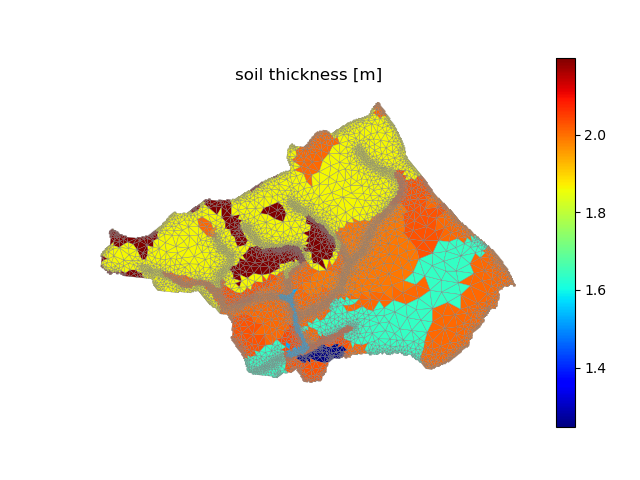

In [37]:
# finally, let's look at the soil thickness, which will define the depth of this layer
soil_thickness = np.zeros(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey, 'thickness [cm]']

print(soil_thickness)
soil_thickness = soil_thickness / 100
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print('Median soil thickness [-] = ', np.nanmedian(soil_thickness))

In [38]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = \
    watershed_workflow.get_shapes(sources['geologic structure'], target_bounds, 
                                  crs, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 10, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)


2024-07-28 13:52:49,675 - root - INFO: target bounds: (754747.6143404754, 187265.87698224248, 758445.4636879219, 189766.83000190117)
2024-07-28 13:52:49,677 - root - INFO: 
2024-07-28 13:52:49,679 - root - INFO: Loading shapes
2024-07-28 13:52:49,680 - root - INFO: ------------------------------
2024-07-28 13:52:49,681 - root - INFO: Getting shapes of GLHYMPS on bounds: (754747.6143404754, 187265.87698224248, 758445.4636879219, 189766.83000190117)
2024-07-28 13:52:49,683 - root - INFO:   from file: /Users/mosesadebayo/Desktop/WADE_SFA_model/watershed Worksflow/data/soil_structure/GLHYMPS/GLHYMPS.shp
2024-07-28 13:52:49,879 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
2024-07-28 13:53:26,089 - root - INFO: ... found 7 shapes
2024-07-28 13:53:26,090 - root - INFO: Converting to shapely
2024-07-28 13:53:26,110 - root - INFO:  ... done
2024-07-28 13:53:26,114 - root - INFO: Converting to requested CRS
2024-07-28 13:53:26,290 - root - INFO:  ... done
2024-07-28 13:53:26,363 - root

/usr/local/anaconda3/envs/watershed_workflow-2022-08-29/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': 'tab20c'}
setting face color =  [1793173. 1793173. 1793173. ... 1793134. 1793134. 1793134.]


id   source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
0   901965  GLHYMPS        1.584893e-12             1.5          0.06   
1   902316  GLHYMPS        1.584893e-12             1.5          0.06   
2   902776  GLHYMPS        1.584893e-12             1.5          0.06   
3  1793134  GLHYMPS        1.584893e-12             1.5          0.06   
4  1793153  GLHYMPS        1.584893e-12             1.5          0.06   
5  1793159  GLHYMPS        3.162278e-17             1.7          0.12   
6  1793173  GLHYMPS        1.584893e-12             1.5          0.06   

   van Genuchten alpha [Pa^-1]  van Genuchten n [-]  residual saturation [-]  
0                     0.002240                  2.0                     0.01  
1                     0.002240                  2.0                     0.01  
2                     0.002240                  2.0                     0.01  
3                     0.002240                  2.0                     0.01  
4                     0.002240                  2.0                     0.01  
5                     0.000007                  2.0                     0.01  
6                     0.002240                  2.0                     0.01

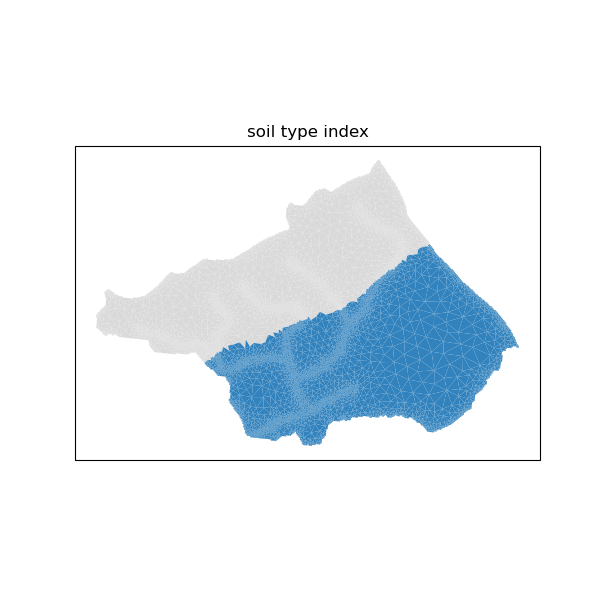

In [39]:
# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, cmap='tab20c')
ax.set_title('soil type index')
geo_survey_props



In [40]:
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], 
                                                                 watershed.exterior(), crs, 
                                                                 nodata=-99999,variable='BDTICM')
                                        #, variable='BDTICM') # note, this argument needed for 
                                        # using the default SoilGrids dataset.

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

2024-07-28 13:53:29,966 - root - INFO: 
2024-07-28 13:53:29,967 - root - INFO: Loading Raster
2024-07-28 13:53:29,968 - root - INFO: ------------------------------
2024-07-28 13:53:29,972 - root - INFO: Collecting raster
2024-07-28 13:53:29,983 - root - INFO: SoilGrids CRS: EPSG:4326
2024-07-28 13:53:29,985 - root - INFO: filename: /Users/mosesadebayo/Desktop/WADE_SFA_model/watershed Worksflow/data/soil_structure/SoilGrids2017/BDTICM_M_250m_ll.tif
2024-07-28 13:53:30,001 - root - INFO: bounds in my_crs: (-84.28313527649101, 36.00865142535742, -84.24215343592965, 36.03109596803092)
2024-07-28 13:53:30,041 - root - INFO: ... got raster of shape: (12, 20)
2024-07-28 13:53:30,044 - root - INFO: ... got raster bounds: (-84.28334864795858, 36.03250821397925, -84.24168198795856, 36.007508217979236)


/usr/local/anaconda3/envs/watershed_workflow-2022-08-29/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


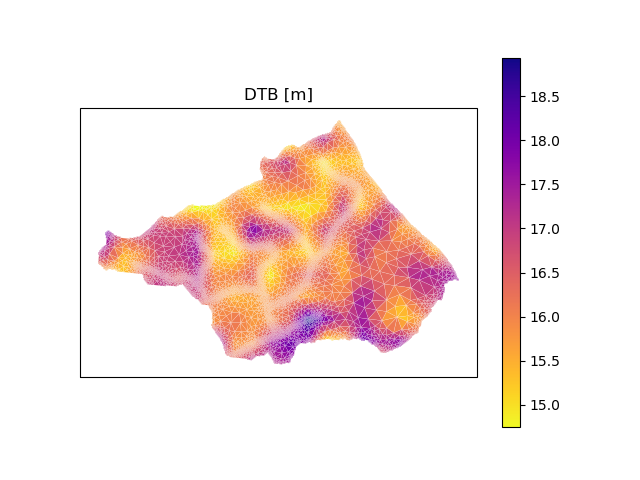

In [41]:
# plot the resulting surface mesh
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp)
title = ax.set_title('DTB [m]')

In [42]:
soil_survey_props['ats_id'] = range(1000, 1000+len(soil_survey_props))
soil_survey_props.set_index('ats_id', inplace=True)

geo_survey_props['ats_id'] = range(100, 100+len(geo_survey_props))
geo_survey_props.set_index('ats_id', inplace=True)

subsurface_props = pandas.concat([geo_survey_props,soil_survey_props])

In [43]:
soil_color[np.isin(soil_color, soil_ids)] = soil_survey_props.index[np.searchsorted(soil_ids, soil_color
                                                                                    [np.isin(soil_color, soil_ids)])].astype(int)
geo_color[np.isin(geo_color, geo_ids)] = geo_survey_props.index[np.searchsorted(geo_ids, geo_color
                                                                                 [np.isin(geo_color, geo_ids)])].astype(int)

In [44]:
# must choose properties for geologic media.  Here we choose one that has a similar porosity
subsurface_props.loc[100, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] =  \
      subsurface_props.loc[1006, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] 

# save the properties to disk for use in generating input file
subsurface_props.to_csv('wade_subsurface_properties_large_model.csv')



In [45]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 1.4, 4,10)
print(dzs)

[0.4087418 0.9912582]


In [46]:
dzs = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
print(sum(dzs))

3.0


In [47]:
dzs = dzs + [2,]*6 + [4,]*2

In [48]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- add the layers
depth = 0
for dz in dzs:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # to set the layer type, we check whether it is
    #   * above the soil thickness (it is soil)
    #   * below the depth to bedrock (it is bedrock)
    #   * else it is geologic layer
    # -- set the depth as the cell midpoint
    depth += 0.5 * dz
    
    # -- bedrock (999) or geologic layer (from geo_color)
    br_or_geo = np.where(depth < DTB, geo_color, 999)
    
    # -- are we in the soil horizons?
    mat_id = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                      soil_color, br_or_geo)

    depth += 0.5 * dz
    layer_mat_ids.append(mat_id)
    
# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2024-07-28 13:53:46,665 - root - INFO: Cell summary:
2024-07-28 13:53:46,666 - root - INFO: ------------------------------------------------------------
2024-07-28 13:53:46,667 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2024-07-28 13:53:46,668 - root - INFO: ------------------------------------------------------------
2024-07-28 13:53:46,669 - root - INFO:  00 	| 00 	| 1016 	|   0.500000 	|   0.000000
2024-07-28 13:53:46,671 - root - INFO:  01 	| 01 	| 1016 	|   0.500000 	|   0.500000
2024-07-28 13:53:46,672 - root - INFO:  02 	| 02 	| 1016 	|   0.500000 	|   1.000000
2024-07-28 13:53:46,673 - root - INFO:  03 	| 03 	| 1016 	|   0.500000 	|   1.500000
2024-07-28 13:53:46,674 - root - INFO:  04 	| 04 	|  106 	|   0.500000 	|   2.000000
2024-07-28 13:53:46,675 - root - INFO:  05 	| 05 	|  106 	|   0.500000 	|   2.500000
2024-07-28 13:53:46,676 - root - INFO:  06 	| 06 	|  106 	|   2.000000 	|   3.000000
2024-07-28 13:53:46,677 - root - INFO:  07 	| 07 	|  106 	|   2.000000 	|   5.0

In [49]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [50]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = watershed_workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.cell_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [51]:
# save to disk
filename = 'wade_bsl_model_meter'

if watershed_workflow.mesh.exodus is not None:
    try:
        os.remove(filename+'.exo')
    except FileNotFoundError:
        pass
    m3.write_exodus(filename+'.exo')

else:
    try:
        os.remove(filename+'.vtk')
    except FileNotFoundError:
        pass
    m3.write_vtk(filename+'.vtk')


You are using exodus.py v 1.21.2 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013-2023 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: wade_bsl_model_meter.exo


2024-07-28 13:54:08,112 - root - INFO: adding side set: 1
2024-07-28 13:54:08,169 - root - INFO: adding side set: 2
2024-07-28 13:54:08,212 - root - INFO: adding side set: 3
2024-07-28 13:54:08,265 - root - INFO: adding side set: 0
2024-07-28 13:54:08,287 - root - INFO: adding side set: 21
2024-07-28 13:54:08,316 - root - INFO: adding side set: 22
2024-07-28 13:54:08,349 - root - INFO: adding side set: 23
2024-07-28 13:54:08,378 - root - INFO: adding side set: 24
2024-07-28 13:54:08,404 - root - INFO: adding side set: 41
2024-07-28 13:54:08,430 - root - INFO: adding side set: 42
2024-07-28 13:54:08,456 - root - INFO: adding side set: 43
2024-07-28 13:54:08,478 - root - INFO: adding side set: 52
2024-07-28 13:54:08,505 - root - INFO: adding side set: 71
2024-07-28 13:54:08,531 - root - INFO: adding side set: 81


Closing exodus file: wade_bsl_model_meter.exo


In [53]:
os.system("/Users/mosesadebayo/desktop/ats/amanzi_tpls-install-master-Debug/bin/meshconvert wade_bsl_model_meter.exo wade_bsl_model_meter_view.exo")


App to convert unstructured meshes between formats
Contact: Rao Garimella (rao@lanl.gov)

Importing mesh from ExodusII file...Building classification information....Done
Exporting mesh to ExodusII/NemesisI format...Done


0

In [212]:
def add_wrm(evaluator, ats_id, props):
    region = soil_set_name(ats_id)
    wrm = wrm_eval['WRM parameters'].append_empty(region)
    wrm.set_type('van Genuchten', ats_input_spec.public.known_specs['WRM-van-Genuchten-spec'])

    wrm['region'] = region
    wrm['van Genuchten alpha [Pa^-1]'] = float(props['van Genuchten alpha [Pa^-1]'])#1.e-4 
    wrm['van Genuchten n [-]'] = float(props['van Genuchten n [-]'])#1.5 
    wrm['residual saturation [-]'] = float(props['residual saturation [-]']) #0.05 
    wrm['smoothing interval width [saturation]'] = 0.05

In [214]:
from itertools import islice

In [260]:
VG_block = '''
          <ParameterList name="NRCS_{}" type="ParameterList">
            <Parameter name="region" type="string" value="NRCS_{}" />
            <Parameter name="WRM Type" type="string" value="van Genuchten" />
            <Parameter name="van Genuchten alpha [Pa^-1]" type="double" value="{}" />
            <Parameter name="van Genuchten n [-]" type="double" value="{}" />
            <Parameter name="residual saturation [-]" type="double" value="{}" />
            <Parameter name="smoothing interval width [saturation]" type="double" value="0.1" />
          </ParameterList>
'''
VG_block2 = '''
          <ParameterList name="GLHYMPS_{}" type="ParameterList">
            <Parameter name="region" type="string" value="GLHYMPS_{}" />
            <Parameter name="WRM Type" type="string" value="van Genuchten" />
            <Parameter name="van Genuchten alpha [Pa^-1]" type="double" value="{}" />
            <Parameter name="van Genuchten n [-]" type="double" value="{}" />
            <Parameter name="residual saturation [-]" type="double" value="{}" />
            <Parameter name="smoothing interval width [saturation]" type="double" value="0.1" />
          </ParameterList>
'''
por_block = '''
          <ParameterList name="NRCS_{}" type="ParameterList">
            <Parameter name="region" type="string" value="NRCS_{}" />
            <Parameter name="component" type="string" value="cell" />
            <ParameterList name="function" type="ParameterList">
              <ParameterList name="function-constant" type="ParameterList">
                <Parameter name="value" type="double" value="{}" />
              </ParameterList>
            </ParameterList>
          </ParameterList>
'''
por_block2 = '''
          <ParameterList name="GLHYMPS_{}" type="ParameterList">
            <Parameter name="region" type="string" value="GLHYMPS_{}" />
            <Parameter name="component" type="string" value="cell" />
            <ParameterList name="function" type="ParameterList">
              <ParameterList name="function-constant" type="ParameterList">
                <Parameter name="value" type="double" value="{}" />
              </ParameterList>
            </ParameterList>
          </ParameterList>
'''


In [262]:
with open('temp.xml', 'w') as fout:
    for ids in np.unique(geo_color).astype(int):
        l1 = geo_survey_props.loc[ids, 'van Genuchten alpha [Pa^-1]']
        l2 = geo_survey_props.loc[ids, 'van Genuchten n [-]']
        l3 = geo_survey_props.loc[ids, 'residual saturation [-]']
        fout.write(VG_block2.format(ids,ids,l1,l2,l3))
    for ids in np.unique(soil_color).astype(int):
        l1 = soil_survey_props.loc[ids, 'van Genuchten alpha [Pa^-1]']
        l2 = soil_survey_props.loc[ids, 'van Genuchten n [-]']
        l3 = soil_survey_props.loc[ids, 'residual saturation [-]']
        fout.write(VG_block.format(ids,ids,l1,l2,l3))
    for ids in np.unique(geo_color).astype(int):
        l1 = geo_survey_props.loc[ids, 'permeability [m^2]']
        fout.write(por_block2.format(ids,ids,l1))
    for ids in np.unique(soil_color).astype(int):
        l1 = soil_survey_props.loc[ids, 'Rosetta permeability [m^2]']
        fout.write(por_block.format(ids,ids,l1)) 
    for ids in np.unique(geo_color).astype(int):
        l1 = geo_survey_props.loc[ids, 'porosity [-]']
        fout.write(por_block2.format(ids,ids,l1))
    for ids in np.unique(soil_color).astype(int):
        l1 = soil_survey_props.loc[ids, 'Rosetta porosity [-]']
        fout.write(por_block.format(ids,ids,l1))

In [346]:
subsurface_props

id   source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
ats_id                                                                         
100      901965.0  GLHYMPS        1.584893e-12             1.5      0.060000   
101      902316.0  GLHYMPS        1.584893e-12             1.5      0.060000   
102      902776.0  GLHYMPS        1.584893e-12             1.5      0.060000   
103     1793134.0  GLHYMPS        1.584893e-12             1.5      0.060000   
104     1793153.0  GLHYMPS        1.584893e-12             1.5      0.060000   
105     1793159.0  GLHYMPS        3.162278e-17             1.7      0.120000   
106     1793173.0  GLHYMPS        1.584893e-12             1.5      0.060000   
1000          NaN     NRCS        8.277264e-13             NaN      0.430311   
1001          NaN     NRCS        9.170000e-13             NaN      0.459595   
1002          NaN     NRCS        9.446941e-13             NaN      0.394346   
1003          NaN     NRCS        2.334663e-13             NaN      0.323003   
1004          NaN     NRCS        2.039371e-13             NaN      0.323003   
1005          NaN     NRCS        1.786660e-13             NaN      0.302745   
1006          NaN     NRCS        2.772173e-13             NaN      0.427061   
1007          NaN     NRCS        2.546018e-13             NaN      0.360745   
1008          NaN     NRCS        2.566853e-13             NaN      0.390250   
1009          NaN     NRCS        2.394577e-13             NaN      0.365596   
1010          NaN     NRCS        3.041200e-13             NaN      0.379458   
1011          NaN     NRCS        9.114758e-13             NaN      0.417989   
1012          NaN     NRCS        2.522765e-12             NaN      0.351160   
1013          NaN     NRCS        9.170000e-13             NaN      0.422337   
1014          NaN     NRCS        9.170000e-13             NaN      0.422377   
1015          NaN     NRCS        9.170000e-13             NaN      0.320052   
1016          NaN     NRCS        1.072671e-12             NaN      0.301483   
1017          NaN     NRCS        1.072671e-12             NaN      0.301483   
1018          NaN     NRCS        9.039799e-13             NaN      0.339124   
1019          NaN     NRCS        9.039799e-13             NaN      0.339124   
1020          NaN     NRCS        1.918317e-13             NaN      0.242812   
1021          NaN     NRCS        2.354358e-13             NaN      0.244350   
1022          NaN     NRCS        1.051828e-12             NaN      0.389491   
1023          NaN     NRCS        7.344550e-13             NaN      0.356203   
1024          NaN     NRCS        3.377298e-14             NaN      0.457653   
1025          NaN     NRCS                 NaN             NaN           NaN   
1026          NaN     NRCS        9.115917e-13             NaN      0.422706   
1027          NaN     NRCS        9.115917e-13             NaN      0.422706   
1028          NaN     NRCS                 NaN             NaN           NaN   

        van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
ats_id                                                     
100                        0.002240             2.000000   
101                        0.002240             2.000000   
102                        0.002240             2.000000   
103                        0.002240             2.000000   
104                        0.002240             2.000000   
105                        0.000007             2.000000   
106                        0.002240             2.000000   
1000                       0.000038             1.477078   
1001                       0.000049             1.426456   
1002                       0.000079             1.353111   
1003                       0.000049             1.376752   
1004                       0.000049             1.376752   
1005                       0.000059             1.329857   
1006                       0.000061             1.335003   
1007          

In [339]:
np.unique(geo_color)

array([103., 106.])

## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

### SSURGO Soil Properties

In [128]:

#soil_profile, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], 
#                                                                   target_bounds, crs, crs, properties=True)#,maxx=2483802.118524286,maxy=620119.2748314698)

In [129]:
#import pandas as pd
#import geopandas as gpd
#gdf=pd.DataFrame({'lat': [2477138.746197727, 2483802.118524286],
#        'lon': [614196.2772078618, 620119.2748314698]})
#gdf=gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.lon, gdf.lat))
#target_bounds = gdf.total_bounds
#logging.info('target bounds: {}'.format(target_bounds))

In [60]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], [wade_intensive.exterior(),],
                                      crs, crs, properties=True)


# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array(soil_survey_props['mukey'][:], np.int32)
    
# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    wade_intensive.exterior().bounds, 1, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)



2025-06-17 01:12:16,186 - root - INFO: 
2025-06-17 01:12:16,187 - root - INFO: Loading shapes
2025-06-17 01:12:16,188 - root - INFO: ------------------------------
2025-06-17 01:12:16,208 - root - INFO: Attempting to download source for target '/home/jovyan/data/soil_structure/SSURGO/SSURGO_-84.3827_35.9585_-84.3773_35.9631.shp'
2025-06-17 01:12:16,268 - root - INFO:   Found 15 shapes.
2025-06-17 01:12:16,270 - root - INFO:   and crs: EPSG:4326
2025-06-17 01:12:16,271 - root - INFO:   Downloaded 15 total shapes
2025-06-17 01:12:16,272 - root - INFO:   Downloaded 6 unique mukeys
2025-06-17 01:12:16,300 - root - INFO: found 6 unique MUKEYs.
2025-06-17 01:12:16,396 - root - INFO: Running Rosetta for van Genutchen parameters
2025-06-17 01:12:16,435 - root - INFO:   ... done
2025-06-17 01:12:16,437 - root - INFO:   requested 6 values
2025-06-17 01:12:16,437 - root - INFO:   got 6 responses
2025-06-17 01:12:16,444 - root - INFO: ... found 6 shapes
2025-06-17 01:12:16,444 - root - INFO: Conve

In [61]:
soil_survey_props

mukey  residual saturation [-]  Rosetta porosity [-]  \
0  1475621                 0.267187              0.413307   
1  1475627                 0.276325              0.421278   
2  1475630                 0.289944              0.433401   
3  1475631                 0.288154              0.431431   
4  1475632                 0.288154              0.431431   
5  1530232                 0.263595              0.412757   

   van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
0                     0.000065             1.337111   
1                     0.000081             1.298283   
2                     0.000080             1.278605   
3                     0.000078             1.283647   
4                     0.000078             1.283647   
5                     0.000078             1.323616   

   Rosetta permeability [m^2]  thickness [cm]  permeability [m^2]  \
0                7.432679e-14          201.75        1.382256e-12   
1                7.778314e-14          184.16        9.330819e-13   
2                6.735238e-14          185.64        1.030242e-12   
3                6.734728e-14          186.20        1.072671e-12   
4                6.734728e-14          186.20        1.072671e-12   
5                8.726528e-14          179.50        6.989786e-13   

   porosity [-]  bulk density [g/cm^3]  total sand pct [%]  \
0      0.333775               1.481410           23.039301   
1      0.388172               1.490202           27.098334   
2      0.299795               1.497747           18.057511   
3      0.301483               1.496303           18.474215   
4      0.301483               1.496303           18.474215   
5      0.366765               1.478458           31.455114   

   total silt pct [%]  total clay pct [%] source  
0           41.770052           35.190647   NRCS  
1           32.313955           40.587711   NRCS  
2           33.941493           48.000996   NRCS  
3           34.798273           46.727511   NRCS  
4           34.798273           46.727511   NRCS  
5           33.906530           34.638357   NRCS

/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f647eb6d510>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x7f647eb6af10>}
setting face color =  [1475621. 1475632. 1475632. ... 1475632. 1475631. 1475631.]


(np.float64(745871.3162),
 np.float64(746374.8258),
 np.float64(181509.01565000002),
 np.float64(182035.35134999998))

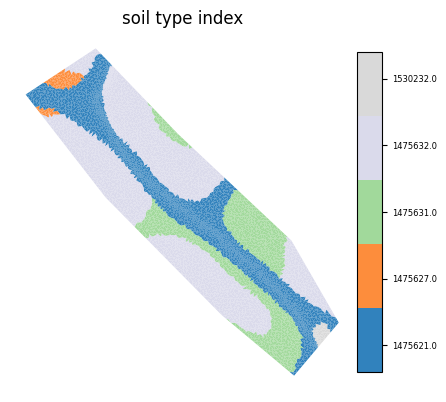

In [62]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = \
        watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.7,0.05,0.05,0.8])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm=norm
                       )

cbar = watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), 
                                                cmap=cmap, labels=labels, cax=cax)
cbar.ax.tick_params(labelsize=6)

ax.set_title('soil type index')
ax.axis('off')



Index(['mukey', 'residual saturation [-]', 'Rosetta porosity [-]',
       'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]',
       'Rosetta permeability [m^2]', 'thickness [cm]', 'permeability [m^2]',
       'porosity [-]', 'bulk density [g/cm^3]', 'total sand pct [%]',
       'total silt pct [%]', 'total clay pct [%]', 'source'],
      dtype='object')
min, max =  0.3014825770143863 0.43143103495030866


/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


(np.float64(745871.3162),
 np.float64(746374.8258),
 np.float64(181509.01565000002),
 np.float64(182035.35134999998))

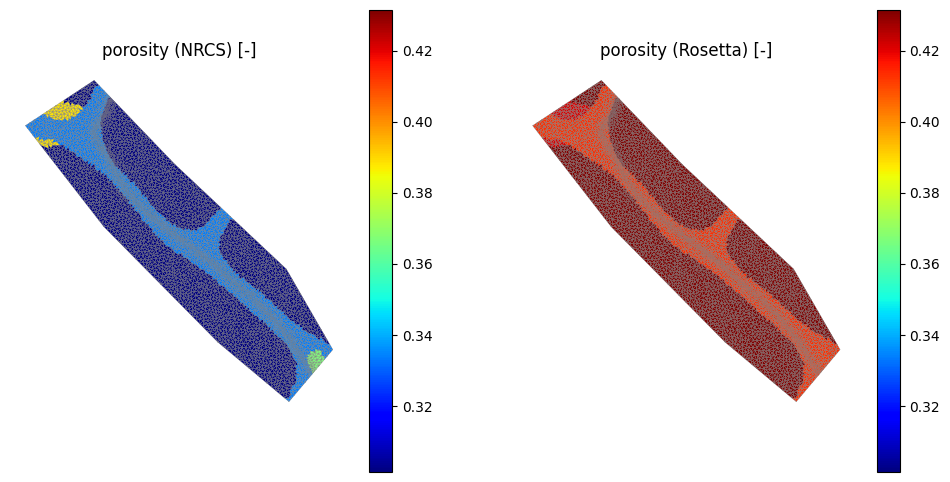

In [63]:
# Note this is not just the soil ID, but also soil properties.  
print(soil_survey_props.keys())
soil_survey_props.set_index('mukey', inplace=True)

# To demonstrate what we mean by this, plot the porosity of the soil column.
porosity_nrcs = np.empty(soil_color.shape, 'd')
porosity_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    porosity_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'porosity [-]']
    porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta porosity [-]']

pmin = min(np.nanmin(porosity_nrcs), np.nanmin(porosity_rosetta))
pmax = max(np.nanmax(porosity_nrcs), np.nanmax(porosity_rosetta))
print('min, max = ', pmin, pmax)


fig = plt.figure(figsize=(12,6))
ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('porosity (NRCS) [-]')
ax1.axis('off')


ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=porosity_rosetta, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('porosity (Rosetta) [-]')
ax2.axis('off')


/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


(np.float64(745871.3162),
 np.float64(746374.8258),
 np.float64(181509.01565000002),
 np.float64(182035.35134999998))

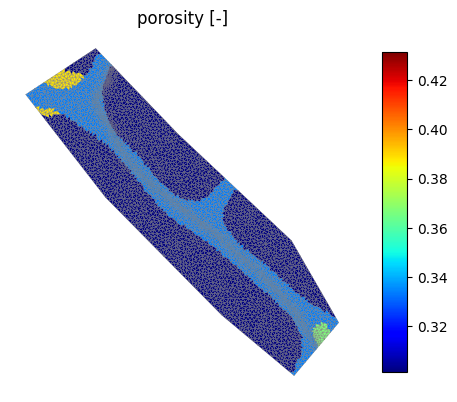

In [64]:
# plot the soil porosity again
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.75,0.05,0.05,0.8])

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp, cax=cax)

ax.set_title('porosity [-]')
ax.axis('off')

min = -13.171679926472986, max = -11.859411392856355


/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'log permeability (Rosetta) [m^2]')

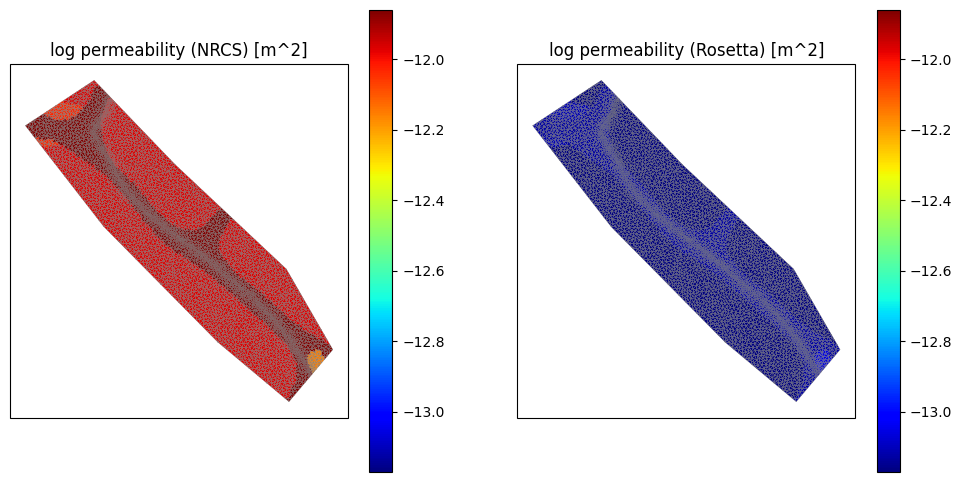

In [65]:
# averaging permeability is a tricky beast.  we average in log space, check that 
# unit conversions make sense
fig = plt.figure(figsize=(12,6))
soil_perm_nrcs = np.empty(soil_color.shape, 'd')
soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    soil_perm_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'permeability [m^2]']
    soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta permeability [m^2]']

pmin = min(np.log10(soil_perm_nrcs).min(), np.log10(soil_perm_rosetta).min())
pmax = max(np.log10(soil_perm_nrcs).max(), np.log10(soil_perm_rosetta).max())

  
print(f'min = {pmin}, max = {pmax}')

ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=np.log10(soil_perm_nrcs), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('log permeability (NRCS) [m^2]')

ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('log permeability (Rosetta) [m^2]')




[201.75 186.2  186.2  ... 186.2  186.2  186.2 ]
Median soil thickness [-] =  1.8619999999999999


/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


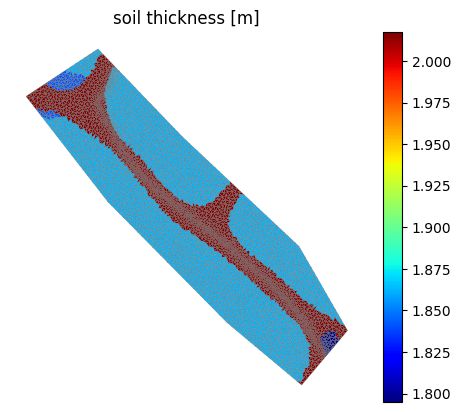

In [66]:
# finally, let's look at the soil thickness, which will define the depth of this layer
soil_thickness = np.zeros(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey, 'thickness [cm]']

print(soil_thickness)
soil_thickness = soil_thickness / 100
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print('Median soil thickness [-] = ', np.nanmedian(soil_thickness))

### GLYHMPS geologic layer

In [75]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = wade_intensive.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = \
    watershed_workflow.get_shapes(sources['geologic structure'], target_bounds, 
                                  crs, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 1, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)


2025-06-17 16:52:15,339 - root - INFO: target bounds: (745894.2031483874, 181532.93992261216, 746351.9387712777, 182011.42703942582)
2025-06-17 16:52:15,341 - root - INFO: 
2025-06-17 16:52:15,342 - root - INFO: Loading shapes
2025-06-17 16:52:15,342 - root - INFO: ------------------------------
2025-06-17 16:52:15,343 - root - INFO: Getting shapes of GLHYMPS on bounds: (745894.2031483874, 181532.93992261216, 746351.9387712777, 182011.42703942582)
2025-06-17 16:52:15,345 - root - INFO:   from file: /home/jovyan/data/soil_structure/GLHYMPS/GLHYMPS.shp
/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
2025-06-17 17:32:21,622 - root - INFO: ... found 2 shapes
2025-06-17 17:32:21,625 - root - INFO: Converting to sha

/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': 'tab20c'}
setting face color =  [1793173. 1793173. 1793173. ... 1793173. 1793173. 1793173.]


id   source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
0  1793134  GLHYMPS        1.584893e-12             1.5          0.06   
1  1793173  GLHYMPS        1.584893e-12             1.5          0.06   

   van Genuchten alpha [Pa^-1]  van Genuchten n [-]  residual saturation [-]  
0                      0.00224                  2.0                     0.01  
1                      0.00224                  2.0                     0.01

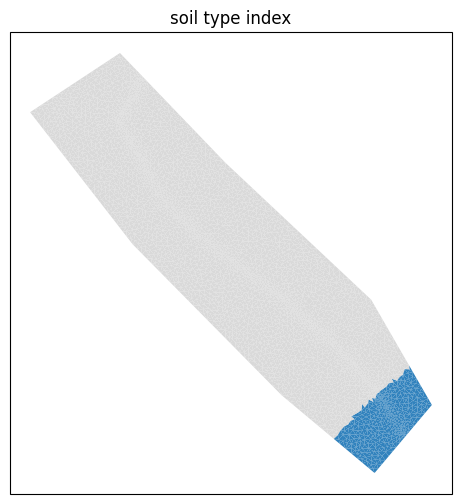

In [76]:
# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, cmap='tab20c')
ax.set_title('soil type index')
geo_survey_props



In [29]:
import numpy as np
import pandas as pd

a = geo_color
replacement_table = pd.DataFrame({1793134: 100}, index=[0])  # Create a DataFrame for replacement

# Convert 'a' to a pandas Series with the same shape as 'replacement_table'
a_series = pd.Series(a, index=np.arange(len(a)))

# Replace values using pandas Series operations
geo_color_new = a_series.replace(replacement_table.columns, replacement_table.values.ravel())

geo_color_new

0       100.0
1       100.0
2       100.0
3       100.0
4       100.0
        ...  
5257    100.0
5258    100.0
5259    100.0
5260    100.0
5261    100.0
Length: 5262, dtype: float64

In [30]:
import numpy as np
import pandas as pd

a = soil_color
replacement_table = pd.DataFrame({1887358: 1000,1887374: 1001,1887407: 1002,1894851: 1003}, index=[0])  # Create a DataFrame for replacement

# Convert 'a' to a pandas Series with the same shape as 'replacement_table'
a_series = pd.Series(a, index=np.arange(len(a)))

# Replace values using pandas Series operations
soil_color_new = a_series.replace(replacement_table.columns, replacement_table.values.ravel())

soil_color_new

0       1002.0
1       1000.0
2       1003.0
3       1000.0
4       1000.0
         ...  
5257    1001.0
5258    1001.0
5259    1000.0
5260    1000.0
5261    1000.0
Length: 5262, dtype: float64

In [123]:
soil_color

array([1887407., 1887358., 1894851., ..., 1894851., 1887407., 1887407.])

## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [79]:
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], 
                                                                 wade_intensive.exterior(), crs, 
                                                                 nodata=-99999,variable='BDTICM')
                                        #, variable='BDTICM') # note, this argument needed for 
                                        # using the default SoilGrids dataset.

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

2025-06-17 19:39:47,438 - root - INFO: 
2025-06-17 19:39:47,440 - root - INFO: Loading Raster
2025-06-17 19:39:47,440 - root - INFO: ------------------------------
2025-06-17 19:39:47,443 - root - INFO: Collecting raster
2025-06-17 19:39:47,535 - rasterio._env - INFO: GDAL signalled an error: err_no=1, msg='BDTICM_M_250m_ll.tif: TIFFFetchDirectory:/home/jovyan/data/soil_structure/SoilGrids2017/BDTICM_M_250m_ll.tif: Can not read TIFF directory count'
2025-06-17 19:39:47,536 - rasterio._env - INFO: GDAL signalled an error: err_no=1, msg='BDTICM_M_250m_ll.tif: TIFFReadDirectory:Failed to read directory at offset 8479362622'


RasterioIOError: BDTICM_M_250m_ll.tif: TIFFReadDirectory:Failed to read directory at offset 8479362622

/opt/conda/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


NameError: name 'DTB' is not defined

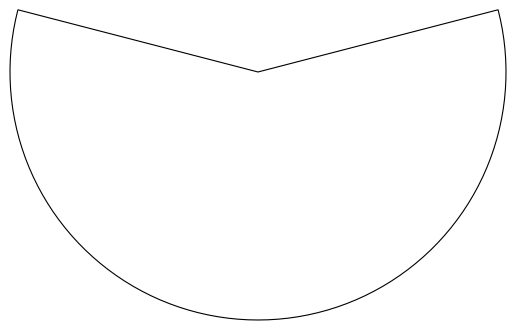

In [80]:
# plot the resulting surface mesh
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp)
title = ax.set_title('DTB [m]')


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs
* 1000-9999 : soil layer material IDs




In [81]:
soil_survey_props['ats_id'] = range(1000, 1000+len(soil_survey_props))
soil_survey_props.set_index('ats_id', inplace=True)

geo_survey_props['ats_id'] = range(100, 100+len(geo_survey_props))
geo_survey_props.set_index('ats_id', inplace=True)

subsurface_props = pandas.concat([geo_survey_props,soil_survey_props])

In [83]:
# must choose properties for geologic media.  Here we choose one that has a similar porosity
subsurface_props.loc[100, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] =  \
      subsurface_props.loc[1000, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] 

# save the properties to disk for use in generating input file
subsurface_props.to_csv('wade_subsurface_properties.csv')



Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [84]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 1.4, 4,10)
print(dzs)

[0.4087418 0.9912582]


In [85]:
# this looks like it would work out:
dzs = [0.4, 0.4, 0.4, 0.4, 0.4]
print(sum(dzs))

2.0


In [86]:
# a 2m soil thickness and a maximum of 20m depth to bedrock suggests a
# geologic layer of 18 - 1m cells
dzs = dzs + [2,]*8


In [87]:
#geo_color_new=geo_color
#soil_color_new=soil_color

In [89]:
DTB=15

In [92]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- add the layers
depth = 0
for dz in dzs:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # to set the layer type, we check whether it is
    #   * above the soil thickness (it is soil)
    #   * below the depth to bedrock (it is bedrock)
    #   * else it is geologic layer
    # -- set the depth as the cell midpoint
    depth += 0.5 * dz
    
    # -- bedrock (999) or geologic layer (from geo_color)
    #br_or_geo = np.where(depth < DTB, geo_color_new, 999)
    
    # -- are we in the soil horizons?
    #mat_id = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
    #                  soil_color_new, br_or_geo)

    depth += 0.5 * dz
    #layer_mat_ids.append(mat_id)
    
# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2025-06-17 19:47:01,427 - root - INFO: Cell summary:
2025-06-17 19:47:01,429 - root - INFO: ------------------------------------------------------------
2025-06-17 19:47:01,430 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2025-06-17 19:47:01,431 - root - INFO: ------------------------------------------------------------


IndexError: list index out of range

In [40]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [46]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = watershed_workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.cell_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [47]:
# save to disk
filename = 'wade_bsl_model_meter_micro'

if watershed_workflow.mesh.exodus is not None:
    try:
        os.remove(filename+'.exo')
    except FileNotFoundError:
        pass
    m3.write_exodus(filename+'.exo')

else:
    try:
        os.remove(filename+'.vtk')
    except FileNotFoundError:
        pass
    m3.write_vtk(filename+'.vtk')

Opening exodus file: wade_bsl_model_meter_micro.exo


2024-02-20 19:04:17,129 - root - INFO: adding side set: 1
2024-02-20 19:04:17,154 - root - INFO: adding side set: 2
2024-02-20 19:04:17,179 - root - INFO: adding side set: 3
2024-02-20 19:04:17,197 - root - INFO: adding side set: 0
2024-02-20 19:04:17,208 - root - INFO: adding side set: 21
2024-02-20 19:04:17,220 - root - INFO: adding side set: 22
2024-02-20 19:04:17,237 - root - INFO: adding side set: 23
2024-02-20 19:04:17,252 - root - INFO: adding side set: 24


Closing exodus file: wade_bsl_model_meter_micro.exo


In [48]:
"""
Example of using meshing_ats.py to generate a simple hillslope.

"""

import sys,os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# This is the standard path for SEACAS if Amanzi TPLS are built via
# bootstrap with --build-shared
try:
    import exodus3 as exodus
except ImportError:
    sys.path.append(os.path.join(os.environ['AMANZI_TPLS_DIR'],'SEACAS', 'lib'))
    import exodus


In [49]:
os.system("/Users/mosesadebayo/desktop/ats/amanzi_tpls-install-master-Debug/bin/meshconvert wade_bsl_model_meter_micro.exo wade_bsl_model_micro_view.exo")


App to convert unstructured meshes between formats
Contact: Rao Garimella (rao@lanl.gov)

Importing mesh from ExodusII file...Building classification information....Done
Exporting mesh to ExodusII/NemesisI format...Done


0